# Neural networks for regression via Tensorflow

### Agenda:
1. What is nonlinear regression?


2. Learn how to do linear and nonlinear regression using Tensorflow. 

    a. How do you set up the computation graph? 
    
    b. How do you train and test the model?
   
   
2. Explain the role of activation functions.

    a. No activation function means you are doing linear regression.
    
    b. What activation function would you choose?

### What is nonlinear regression?

Given $X$ and $Y$ data, find a function $F$ that best explains the relationship between $X$ and $Y$, i.e., find $F$ such that $Y \approx F(X)$. Regression is the act of finding a suitable $F$. When $F$ is restricted to be linear, you are performing linear regression. It is the multivariate form of your familiar question: "fit the best line to given data". When $F$ can be nonlinear, finding that function $F$ is called nonlinear regression.

Given: $({X}_1, {Y}_1), \ldots, ({X}_n, {Y}_n)$. 

Objective: Find $F$ that minimizes the error between $Y$ and $F(X)$ on the data, i.e., solve
$$ \underset{F}{\text{minimize}}\ \ \frac{1}{n}\sum_{i=1}^n \| {Y}_i - F({X}_i) \|^2. $$

 
### What is a neural network and how can it do nonlinear regression?
A neural network defines a sequence of operations on the input that produces an output. In the above diagram, your data $X$ goes through the neural network to produce the output $Y$. What does each layer represent? With the output of the last layer, it performs an affine transformation and then passes it through an **activation function** to compute the output of the current layer.

<img src="neuralNet.png"  width="700">

In essence, a neural network **parameterizes** the function $F$ in terms of the weights and biases in the neural network. In the above figure, the parameters are given by
$$\theta := ( W^1, b^1, W^2, b^2 ).$$
Call this parametric representation $F_\theta$. Then, the nonlinear regression via a neural network seeks $\theta$ that solves
$$ \underset{\theta}{\text{minimize}}\ \ J(\theta) := \frac{1}{n}\sum_{i=1}^n \| {Y}_i - F_\theta({X}_i) \|^2. $$


### How does a neural network optimize over $\theta$?

There are a variety of optimizer routines that one can use, the simplest among them is **stochastic gradient descent**. You sample one among your $n$ data points and sequentially update the parameters in $\theta$ as follows. 
$$ \theta_{k+1} := \theta_{k} - \alpha_k \nabla_\theta \| {Y}_i - F_\theta({X}_i) \|^2, $$
starting from a possibly random initial parameter vector $\theta_0$. Here, $\alpha$'s define a sequence of stepsizes, and $\nabla J$ stands for the gradient of $J$.

1. Can you use one data point at a time to perform an update? If so, how should you sample the data?
2. Can you update $\theta$ using a batch of gradients computed on a batch of data? 
3. Can you have different step-sizes for different parameters within $\theta$?
4. How fast does it converge?

Machine learning research has focussed on each of these questions both using theoretical analysis and extensive simulation studies.


### In the parametric description of $F$, what is an activation function?

Without activation function, the output of the neural network is a linear function of $X$. To understand that statement, assume in the above network that activation function is identity, and therefore, we have $Z = X W^1 + b^1$, and 
$$ Y = Z W^2 + b^2 = ( X W^1 + b^1 ) W^2 + b^2 = X (W^1 W^2) + b^1 W^2 + b^2, $$
a linear function of $X$. Utilizing the same logic, you can show that no matter how many layers you have or how many neurons you have in these layers, the output of a neural network is linear in $X$ without an activation function. You need a nonlinear activation function to learn complicated nonlinear functions.

## Example: Nonlinear regression via Tensorflow.

Construct $n=1000$ data points $({X}_1, {Y}_1), \ldots ({X}_n, {Y}_n)$, where ${Y}_i = F({X}_i)$. Obtain the ${X}$'s by sampling uniformly between -5 and 5, n times.

Start with the customary imports.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

### Prepare the training data.

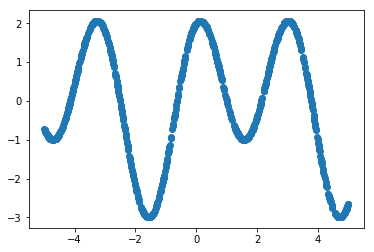

In [2]:
# Prepare training data in Xbar and Ybar.

n = 1000
trainX = np.random.uniform(-5, 5, size=[n, 1])
F = lambda x: np.sin(x) + 2 * np.cos(2 * x)
trainY = np.array([F(x) for x in trainX])

# Draw a scatter plot of the sampled points.
plt.figure(1)
plt.scatter(trainX, trainY)
plt.show()

### Define the test data.

Create a data set of $m=200$ points from $[-5, 5]$ on which you will test the accuracy of the regressor. Always keep the training and testing data different. If you don't and you seek to minimize training error, you may overfit your regressor to your training samples. Overfitting means that you fit the regressor so well on the training set, that it starts to perform way worse on samples it has never seen before. That is, your learnt function does not accurately capture the true relationship between $X$ and $Y$. 

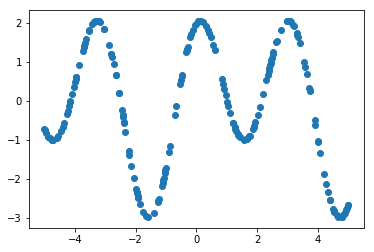

In [3]:
m = 200
testX = np.random.uniform(-5, 5, size=[m, 1])
testY = np.array([F(x) for x in testX])

plt.figure(1)
plt.scatter(testX, testY)
plt.show()

### Use Tensorflow to learn the function. 

Tensorflow allows you to construct a neural network as a computation graph. When you define the computation graph, it does not compute anything, but rather defines the sequence of operations that you will perform on the data. The data you will supply should be defined as placeholders, and the parameters defining the neural network should be defined as variables.

In [4]:
# Define the structure of the neural network as a computation graph in Tensorflow.
X = tf.placeholder(dtype=tf.float32, shape=[None, 1])

nHidden = 15

W1 = tf.Variable(tf.truncated_normal(shape=[1, nHidden]))
b1 = tf.Variable(tf.truncated_normal(shape=[nHidden]))
Z1 = tf.nn.relu(tf.matmul(X, W1) + b1)

W2 = tf.Variable(tf.truncated_normal(shape=[nHidden, 1]))
b2 = tf.Variable(tf.truncated_normal(shape=[1]))
Yhat = tf.matmul(Z1, W2) + b2

Few comments about the above code:

1. $X$ will only be defined at runtime, and is left unspecified, except possibly its size. Notice that the first among the shape parameters is 'None'. This indicates to Tensorflow that we may pass multiple $X$'s to train or test the neural network. The second shape parameter being 1, our input data is scalar.

2. How many hidden layers does this neural network have? There is one hidden layer with 15 neurons.

3. What constitutes the parameters $\theta$ for this neural network that we aim to optimize over? Weights W1, W2 and biases b1, b2.

4. The activation function used here is 'relu'. We will learn more about activation functions.

### Define the optimization routine for training the neural network.

We aim to find $\theta$ that minimizes the discrepancy between 'trainY' and $F_\theta$ applied on 'trainX'. Define the target $Y$ as a placeholder and define an optimizer to minimize the mean squared distance between the neural network predictions $\hat{Y}$ and its target $Y$. Similar to $X$, the placeholder $Y$ can have variable shape, depending upon how many data points are used to train or test the neural network. Therefore, define the first argument in its shape parameter as 'None', and the second arguemnt as one. 

**Question.** Why is the second argument in the shape of $Y$ equal to 1?

In [5]:
Y = tf.placeholder(dtype=tf.float32, shape=[None, 1])

# Define a loss function.
loss = tf.losses.mean_squared_error(labels=Y, predictions=Yhat)

# Define the optimizer.
optimizer = tf.train.AdamOptimizer(learning_rate=0.35).minimize(loss)

**Question.** Can you relate 'learning_rate' to our iterative description of how $\theta$'s are updated?

### Define a metric to judge the accuracy of prediction via neural network.

To evaluate the performance of your regressor, you need to define an accuracy metric. A commonly used metric for nonlinear regression is "root mean squared error" (RMSE). On any test data, if the neural network produces $\hat{Y}_1, \ldots, \hat{Y}_m$, and the true values are $Y_1, \ldots, Y_m$, then the RMSE of the prediction is given by
$$ \text{RMSE} = \sqrt{\sum_{i=1}^m \frac{(Y_i - \hat{Y}_i)^2}{N}}.$$


In [6]:
_, accuracy = tf.metrics.root_mean_squared_error(labels=Y, predictions=Yhat)

**Question.** Why don't we use the function 'accuracy' as the 'loss' function and seek to minimize the RMSE?

### Train the classifier in a Tensorflow session.

Having defined the computation graph, we now train the neural network. In a session, you initialize an instance of the computation graph, and pass the data ${X}, {Y}$ to it multiple times (called 'epochs'), and run the optimizer function. 

In [7]:
sess = tf.Session()
with sess.as_default():

    # Initialize the computation graph. 
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    print("Started the training module.")

    # Define the number of epochs.
    nEpochs = 4000
    
    for epoch in range(nEpochs):

        lossEpoch = 0
        # In each epoch, use 'optimizer' to reduce the 'loss' over the entire data. Make sure to pass
        # the appropriate data to the placeholders.
        _, lossEpoch = sess.run([optimizer, loss], feed_dict={X: trainX, Y: trainY})
         
        print("Epoch: %d, Loss: = %1.1f" % (epoch + 1, lossEpoch))

    print("End of training process...")

Started the training module.
Epoch: 1, Loss: = 58.0
Epoch: 2, Loss: = 45.0
Epoch: 3, Loss: = 37.5
Epoch: 4, Loss: = 11.5
Epoch: 5, Loss: = 6.2
Epoch: 6, Loss: = 10.9
Epoch: 7, Loss: = 13.3
Epoch: 8, Loss: = 11.2
Epoch: 9, Loss: = 7.6
Epoch: 10, Loss: = 4.7
Epoch: 11, Loss: = 3.4
Epoch: 12, Loss: = 4.1
Epoch: 13, Loss: = 5.4
Epoch: 14, Loss: = 5.7
Epoch: 15, Loss: = 4.7
Epoch: 16, Loss: = 3.7
Epoch: 17, Loss: = 3.2
Epoch: 18, Loss: = 2.8
Epoch: 19, Loss: = 2.6
Epoch: 20, Loss: = 2.3
Epoch: 21, Loss: = 2.1
Epoch: 22, Loss: = 2.0
Epoch: 23, Loss: = 1.9
Epoch: 24, Loss: = 1.9
Epoch: 25, Loss: = 1.9
Epoch: 26, Loss: = 1.9
Epoch: 27, Loss: = 1.9
Epoch: 28, Loss: = 1.8
Epoch: 29, Loss: = 1.8
Epoch: 30, Loss: = 1.7
Epoch: 31, Loss: = 1.7
Epoch: 32, Loss: = 1.6
Epoch: 33, Loss: = 1.6
Epoch: 34, Loss: = 1.5
Epoch: 35, Loss: = 1.5
Epoch: 36, Loss: = 1.4
Epoch: 37, Loss: = 1.4
Epoch: 38, Loss: = 1.3
Epoch: 39, Loss: = 1.2
Epoch: 40, Loss: = 1.2
Epoch: 41, Loss: = 1.1
Epoch: 42, Loss: = 1.1
Epoch: 

Epoch: 371, Loss: = 0.4
Epoch: 372, Loss: = 0.5
Epoch: 373, Loss: = 0.5
Epoch: 374, Loss: = 0.4
Epoch: 375, Loss: = 0.4
Epoch: 376, Loss: = 0.5
Epoch: 377, Loss: = 0.5
Epoch: 378, Loss: = 0.4
Epoch: 379, Loss: = 0.4
Epoch: 380, Loss: = 0.4
Epoch: 381, Loss: = 0.5
Epoch: 382, Loss: = 0.4
Epoch: 383, Loss: = 0.4
Epoch: 384, Loss: = 0.4
Epoch: 385, Loss: = 0.4
Epoch: 386, Loss: = 0.4
Epoch: 387, Loss: = 0.4
Epoch: 388, Loss: = 0.4
Epoch: 389, Loss: = 0.4
Epoch: 390, Loss: = 0.4
Epoch: 391, Loss: = 0.4
Epoch: 392, Loss: = 0.4
Epoch: 393, Loss: = 0.4
Epoch: 394, Loss: = 0.4
Epoch: 395, Loss: = 0.4
Epoch: 396, Loss: = 0.4
Epoch: 397, Loss: = 0.4
Epoch: 398, Loss: = 0.4
Epoch: 399, Loss: = 0.4
Epoch: 400, Loss: = 0.4
Epoch: 401, Loss: = 0.4
Epoch: 402, Loss: = 0.4
Epoch: 403, Loss: = 0.4
Epoch: 404, Loss: = 0.4
Epoch: 405, Loss: = 0.4
Epoch: 406, Loss: = 0.4
Epoch: 407, Loss: = 0.4
Epoch: 408, Loss: = 0.4
Epoch: 409, Loss: = 0.4
Epoch: 410, Loss: = 0.4
Epoch: 411, Loss: = 0.4
Epoch: 412, Loss

Epoch: 828, Loss: = 0.5
Epoch: 829, Loss: = 0.6
Epoch: 830, Loss: = 0.8
Epoch: 831, Loss: = 1.1
Epoch: 832, Loss: = 1.5
Epoch: 833, Loss: = 1.6
Epoch: 834, Loss: = 1.7
Epoch: 835, Loss: = 1.1
Epoch: 836, Loss: = 0.5
Epoch: 837, Loss: = 0.5
Epoch: 838, Loss: = 0.8
Epoch: 839, Loss: = 0.9
Epoch: 840, Loss: = 0.5
Epoch: 841, Loss: = 0.5
Epoch: 842, Loss: = 0.7
Epoch: 843, Loss: = 0.7
Epoch: 844, Loss: = 0.5
Epoch: 845, Loss: = 0.5
Epoch: 846, Loss: = 0.6
Epoch: 847, Loss: = 0.5
Epoch: 848, Loss: = 0.4
Epoch: 849, Loss: = 0.5
Epoch: 850, Loss: = 0.5
Epoch: 851, Loss: = 0.5
Epoch: 852, Loss: = 0.4
Epoch: 853, Loss: = 0.5
Epoch: 854, Loss: = 0.5
Epoch: 855, Loss: = 0.4
Epoch: 856, Loss: = 0.4
Epoch: 857, Loss: = 0.4
Epoch: 858, Loss: = 0.5
Epoch: 859, Loss: = 0.4
Epoch: 860, Loss: = 0.4
Epoch: 861, Loss: = 0.4
Epoch: 862, Loss: = 0.4
Epoch: 863, Loss: = 0.4
Epoch: 864, Loss: = 0.4
Epoch: 865, Loss: = 0.4
Epoch: 866, Loss: = 0.4
Epoch: 867, Loss: = 0.4
Epoch: 868, Loss: = 0.4
Epoch: 869, Loss

Epoch: 1264, Loss: = 0.5
Epoch: 1265, Loss: = 0.6
Epoch: 1266, Loss: = 0.5
Epoch: 1267, Loss: = 0.5
Epoch: 1268, Loss: = 0.5
Epoch: 1269, Loss: = 0.5
Epoch: 1270, Loss: = 0.5
Epoch: 1271, Loss: = 0.5
Epoch: 1272, Loss: = 0.5
Epoch: 1273, Loss: = 0.5
Epoch: 1274, Loss: = 0.4
Epoch: 1275, Loss: = 0.5
Epoch: 1276, Loss: = 0.4
Epoch: 1277, Loss: = 0.4
Epoch: 1278, Loss: = 0.4
Epoch: 1279, Loss: = 0.4
Epoch: 1280, Loss: = 0.4
Epoch: 1281, Loss: = 0.4
Epoch: 1282, Loss: = 0.4
Epoch: 1283, Loss: = 0.4
Epoch: 1284, Loss: = 0.4
Epoch: 1285, Loss: = 0.4
Epoch: 1286, Loss: = 0.4
Epoch: 1287, Loss: = 0.4
Epoch: 1288, Loss: = 0.4
Epoch: 1289, Loss: = 0.4
Epoch: 1290, Loss: = 0.4
Epoch: 1291, Loss: = 0.4
Epoch: 1292, Loss: = 0.4
Epoch: 1293, Loss: = 0.4
Epoch: 1294, Loss: = 0.4
Epoch: 1295, Loss: = 0.4
Epoch: 1296, Loss: = 0.4
Epoch: 1297, Loss: = 0.4
Epoch: 1298, Loss: = 0.4
Epoch: 1299, Loss: = 0.4
Epoch: 1300, Loss: = 0.4
Epoch: 1301, Loss: = 0.4
Epoch: 1302, Loss: = 0.4
Epoch: 1303, Loss: = 0.4


Epoch: 1740, Loss: = 0.5
Epoch: 1741, Loss: = 0.5
Epoch: 1742, Loss: = 0.5
Epoch: 1743, Loss: = 0.5
Epoch: 1744, Loss: = 0.4
Epoch: 1745, Loss: = 0.5
Epoch: 1746, Loss: = 0.5
Epoch: 1747, Loss: = 0.4
Epoch: 1748, Loss: = 0.4
Epoch: 1749, Loss: = 0.5
Epoch: 1750, Loss: = 0.4
Epoch: 1751, Loss: = 0.4
Epoch: 1752, Loss: = 0.4
Epoch: 1753, Loss: = 0.4
Epoch: 1754, Loss: = 0.4
Epoch: 1755, Loss: = 0.4
Epoch: 1756, Loss: = 0.4
Epoch: 1757, Loss: = 0.4
Epoch: 1758, Loss: = 0.4
Epoch: 1759, Loss: = 0.4
Epoch: 1760, Loss: = 0.4
Epoch: 1761, Loss: = 0.4
Epoch: 1762, Loss: = 0.4
Epoch: 1763, Loss: = 0.4
Epoch: 1764, Loss: = 0.4
Epoch: 1765, Loss: = 0.4
Epoch: 1766, Loss: = 0.4
Epoch: 1767, Loss: = 0.4
Epoch: 1768, Loss: = 0.4
Epoch: 1769, Loss: = 0.4
Epoch: 1770, Loss: = 0.4
Epoch: 1771, Loss: = 0.4
Epoch: 1772, Loss: = 0.4
Epoch: 1773, Loss: = 0.4
Epoch: 1774, Loss: = 0.4
Epoch: 1775, Loss: = 0.4
Epoch: 1776, Loss: = 0.4
Epoch: 1777, Loss: = 0.4
Epoch: 1778, Loss: = 0.4
Epoch: 1779, Loss: = 0.4


Epoch: 2207, Loss: = 0.4
Epoch: 2208, Loss: = 0.4
Epoch: 2209, Loss: = 0.4
Epoch: 2210, Loss: = 0.4
Epoch: 2211, Loss: = 0.4
Epoch: 2212, Loss: = 0.4
Epoch: 2213, Loss: = 0.4
Epoch: 2214, Loss: = 0.4
Epoch: 2215, Loss: = 0.4
Epoch: 2216, Loss: = 0.4
Epoch: 2217, Loss: = 0.4
Epoch: 2218, Loss: = 0.4
Epoch: 2219, Loss: = 0.4
Epoch: 2220, Loss: = 0.4
Epoch: 2221, Loss: = 0.4
Epoch: 2222, Loss: = 0.4
Epoch: 2223, Loss: = 0.4
Epoch: 2224, Loss: = 0.4
Epoch: 2225, Loss: = 0.4
Epoch: 2226, Loss: = 0.4
Epoch: 2227, Loss: = 0.4
Epoch: 2228, Loss: = 0.4
Epoch: 2229, Loss: = 0.4
Epoch: 2230, Loss: = 0.4
Epoch: 2231, Loss: = 0.4
Epoch: 2232, Loss: = 0.4
Epoch: 2233, Loss: = 0.4
Epoch: 2234, Loss: = 0.4
Epoch: 2235, Loss: = 0.4
Epoch: 2236, Loss: = 0.4
Epoch: 2237, Loss: = 0.4
Epoch: 2238, Loss: = 0.4
Epoch: 2239, Loss: = 0.4
Epoch: 2240, Loss: = 0.4
Epoch: 2241, Loss: = 0.5
Epoch: 2242, Loss: = 0.5
Epoch: 2243, Loss: = 0.6
Epoch: 2244, Loss: = 0.7
Epoch: 2245, Loss: = 0.8
Epoch: 2246, Loss: = 1.0


Epoch: 2711, Loss: = 1.2
Epoch: 2712, Loss: = 1.0
Epoch: 2713, Loss: = 0.6
Epoch: 2714, Loss: = 0.4
Epoch: 2715, Loss: = 0.5
Epoch: 2716, Loss: = 0.7
Epoch: 2717, Loss: = 0.7
Epoch: 2718, Loss: = 0.5
Epoch: 2719, Loss: = 0.4
Epoch: 2720, Loss: = 0.5
Epoch: 2721, Loss: = 0.6
Epoch: 2722, Loss: = 0.5
Epoch: 2723, Loss: = 0.4
Epoch: 2724, Loss: = 0.5
Epoch: 2725, Loss: = 0.5
Epoch: 2726, Loss: = 0.5
Epoch: 2727, Loss: = 0.5
Epoch: 2728, Loss: = 0.4
Epoch: 2729, Loss: = 0.4
Epoch: 2730, Loss: = 0.5
Epoch: 2731, Loss: = 0.5
Epoch: 2732, Loss: = 0.4
Epoch: 2733, Loss: = 0.4
Epoch: 2734, Loss: = 0.4
Epoch: 2735, Loss: = 0.4
Epoch: 2736, Loss: = 0.4
Epoch: 2737, Loss: = 0.4
Epoch: 2738, Loss: = 0.4
Epoch: 2739, Loss: = 0.4
Epoch: 2740, Loss: = 0.4
Epoch: 2741, Loss: = 0.4
Epoch: 2742, Loss: = 0.4
Epoch: 2743, Loss: = 0.4
Epoch: 2744, Loss: = 0.4
Epoch: 2745, Loss: = 0.4
Epoch: 2746, Loss: = 0.4
Epoch: 2747, Loss: = 0.4
Epoch: 2748, Loss: = 0.4
Epoch: 2749, Loss: = 0.4
Epoch: 2750, Loss: = 0.4


Epoch: 3216, Loss: = 0.4
Epoch: 3217, Loss: = 0.4
Epoch: 3218, Loss: = 0.4
Epoch: 3219, Loss: = 0.4
Epoch: 3220, Loss: = 0.4
Epoch: 3221, Loss: = 0.4
Epoch: 3222, Loss: = 0.4
Epoch: 3223, Loss: = 0.4
Epoch: 3224, Loss: = 0.4
Epoch: 3225, Loss: = 0.4
Epoch: 3226, Loss: = 0.4
Epoch: 3227, Loss: = 0.4
Epoch: 3228, Loss: = 0.4
Epoch: 3229, Loss: = 0.4
Epoch: 3230, Loss: = 0.4
Epoch: 3231, Loss: = 0.4
Epoch: 3232, Loss: = 0.4
Epoch: 3233, Loss: = 0.4
Epoch: 3234, Loss: = 0.4
Epoch: 3235, Loss: = 0.4
Epoch: 3236, Loss: = 0.4
Epoch: 3237, Loss: = 0.4
Epoch: 3238, Loss: = 0.4
Epoch: 3239, Loss: = 0.4
Epoch: 3240, Loss: = 0.4
Epoch: 3241, Loss: = 0.4
Epoch: 3242, Loss: = 0.4
Epoch: 3243, Loss: = 0.4
Epoch: 3244, Loss: = 0.4
Epoch: 3245, Loss: = 0.4
Epoch: 3246, Loss: = 0.4
Epoch: 3247, Loss: = 0.4
Epoch: 3248, Loss: = 0.4
Epoch: 3249, Loss: = 0.4
Epoch: 3250, Loss: = 0.4
Epoch: 3251, Loss: = 0.4
Epoch: 3252, Loss: = 0.4
Epoch: 3253, Loss: = 0.4
Epoch: 3254, Loss: = 0.4
Epoch: 3255, Loss: = 0.4


Epoch: 3710, Loss: = 0.4
Epoch: 3711, Loss: = 0.4
Epoch: 3712, Loss: = 0.4
Epoch: 3713, Loss: = 0.4
Epoch: 3714, Loss: = 0.4
Epoch: 3715, Loss: = 0.4
Epoch: 3716, Loss: = 0.4
Epoch: 3717, Loss: = 0.4
Epoch: 3718, Loss: = 0.4
Epoch: 3719, Loss: = 0.4
Epoch: 3720, Loss: = 0.4
Epoch: 3721, Loss: = 0.4
Epoch: 3722, Loss: = 0.4
Epoch: 3723, Loss: = 0.4
Epoch: 3724, Loss: = 0.4
Epoch: 3725, Loss: = 0.4
Epoch: 3726, Loss: = 0.4
Epoch: 3727, Loss: = 0.4
Epoch: 3728, Loss: = 0.4
Epoch: 3729, Loss: = 0.4
Epoch: 3730, Loss: = 0.4
Epoch: 3731, Loss: = 0.4
Epoch: 3732, Loss: = 0.4
Epoch: 3733, Loss: = 0.4
Epoch: 3734, Loss: = 0.4
Epoch: 3735, Loss: = 0.4
Epoch: 3736, Loss: = 0.4
Epoch: 3737, Loss: = 0.4
Epoch: 3738, Loss: = 0.4
Epoch: 3739, Loss: = 0.4
Epoch: 3740, Loss: = 0.5
Epoch: 3741, Loss: = 0.5
Epoch: 3742, Loss: = 0.5
Epoch: 3743, Loss: = 0.6
Epoch: 3744, Loss: = 0.7
Epoch: 3745, Loss: = 0.8
Epoch: 3746, Loss: = 1.0
Epoch: 3747, Loss: = 1.0
Epoch: 3748, Loss: = 1.0
Epoch: 3749, Loss: = 0.8


If you don't think your neural network has converged, play with the learning rate, number of epochs, activation functions, etc.

#### Test the accuracy on test data and visualize it.

RMSE of regressor on test data = 0.64


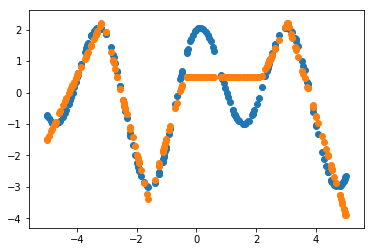

In [8]:
    # You are still inside the session. Notice the indentation!
    
    # Output the accuracy of the regressor on the test data.
    predictedY, accuracyOfPrediction = sess.run([Yhat, accuracy], feed_dict={X: testX, Y: testY})
    print("RMSE of regressor on test data = %1.2f" % accuracyOfPrediction)
    
    plt.figure(2)
    plt.scatter(testX, testY)
    plt.scatter(testX, np.array(predictedY))
    plt.show()

### Exercises: Check the result after making each of these changes. Make a note of your observations. Change back to the original setting for the next exercise.

1. Change the number of neurons in the hidden layer to 3.
2. Change back the number of hidden neurons to 15 and then remove the activation function in the hidden layer.
3. Keep the activation in the hidden layer as 'relu', and additionally use a relu activation on the output layer.
4. Remove activation in the output layer, but use a 'tanh' activation in the hidden layer.
5. Vary the learning rate and check the quality of the training.